# Assignment 5
# Group Members : 
# Rohan Jijju 181EC138
# Roshan Rangarajan 181EC139

## Question 1 from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

In [2]:
X = np.loadtxt(r"C:\Users\user\Desktop\X_train.txt")
Y = (np.loadtxt(r"C:\Users\user\Desktop\Y_train.txt") - 1).astype("int")

In [3]:
activity_dictionary = {0:"WALKING",1:"WALKING_UPSTAIRS",2:"WALKING_DOWNSTAIRS",3:"SITTING",4:"STANDING",5:"LAYING"}

Visualization

Frequency of each activity in dataset


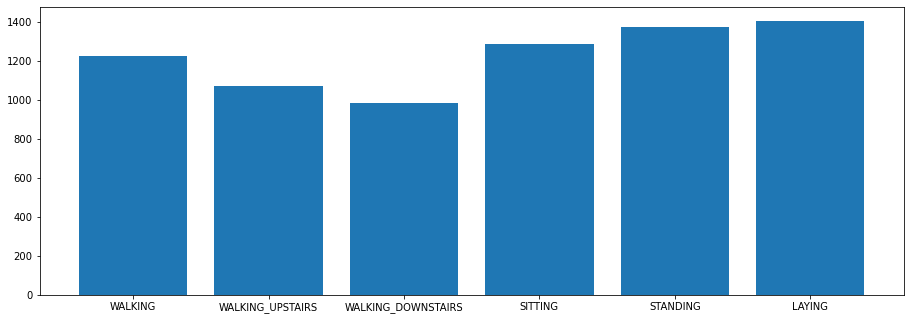

In [4]:
print("Frequency of each activity in dataset")

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
activities = list(activity_dictionary.values())
frequency = [np.sum(Y == i) for i in range(6)]
ax.bar(activities,frequency)
plt.title
plt.show()

Preparing data

In [5]:
X,Y = shuffle(X,Y)

In [6]:
def one_hot(Y, no_of_classes):
    Y_one_hot = np.zeros((len(Y),no_of_classes),dtype = "float")
    for i in range(len(Y)):
        Y_one_hot[i,Y[i]] = 1.
    return Y_one_hot

In [7]:
Y_encoded = one_hot(Y, 6)

In [8]:
X_train = X[:int(0.8*len(X))]
Y_train = Y_encoded[:int(0.8*len(X))]

X_test = X[int(0.8*len(X)):]
Y_test = Y_encoded[int(0.8*len(X)):]

Creating the model

In [9]:
def relu(X):
    return X*(X>0)

def relu_der(X):
    return 1*(X>0)

In [10]:
def stable_softmax(X):
    exps = np.exp(X - np.expand_dims(np.max(X, axis = 1),axis = 1))
    return exps / np.expand_dims(np.sum(exps, axis = 1),axis = 1)

In [11]:
def softmax_cross_entropy_derivative(X,y):
    grad = stable_softmax(X)
    grad[y] -= 1
    return grad

In [18]:
def get_forward_prop(X, w_cnn, w_dense):
    
    conv_layer_out = np.zeros((np.shape(X)[0],np.shape(X)[1] - len(w_cnn) + 2))
    conv_layer_out_act = np.zeros((np.shape(X)[0],np.shape(X)[1] - len(w_cnn) + 2))
    average_pool_layer_out = np.zeros((np.shape(X)[0],int((np.shape(X)[1] - len(w_cnn) + 2)/2)))
    
    for i in range(len(X)):
        conv_layer_out[i] = np.append(np.correlate(X[i], w_cnn),0)
        conv_layer_out_act[i] = relu(conv_layer_out[i])
        average_pool_layer_out[i] = conv_layer_out_act[i].reshape((int(len(conv_layer_out[i])/2),2)).mean(axis = 1)
    
    dense_layer_out = np.matmul(average_pool_layer_out,w_dense)
    dense_layer_out_act = stable_softmax(dense_layer_out)
    
    return conv_layer_out, conv_layer_out_act, average_pool_layer_out, dense_layer_out, dense_layer_out_act

In [19]:
def get_loss(Y,Y_pred):
    return -np.mean(np.log(np.take_along_axis(Y_pred,np.expand_dims(Y,axis = 1),1) + 0.00000001))

In [31]:
def sgd(X,Y,lr = 0.01,epoch = 10, batch_size = 32):
    
    w_cnn = np.random.randn(5)*0.01
    w_dense = np.random.randn(279,6)*0.01
    
    loss_values = []
    
    no_of_batches = int(len(X)/batch_size) - 1
    
    for k in range(epoch):
        print("Epoch number - " + str(k))
        
        _,_,_,_,out = get_forward_prop(X, w_cnn, w_dense)
        
        loss = get_loss(Y.argmax(axis = 1),out)
        loss_values.append(loss)
        
        print("Loss - " + str(loss))
        print("Accuracy - " + str(np.mean(Y.argmax(axis = 1) == out.argmax(axis = 1))))
        
        for i in range(no_of_batches):
            X_batched = X[i*batch_size:(i+1)*batch_size]
            Y_batched = Y[i*batch_size:(i+1)*batch_size]
            
            conv_layer_out, conv_layer_out_act, average_pool_layer_out, dense_layer_out, dense_layer_out_act = get_forward_prop(X_batched, w_cnn, w_dense)
            
            d_loss_d_out = softmax_cross_entropy_derivative(dense_layer_out,np.where(Y_batched))
            
            dw_dense = np.zeros(np.shape(w_dense))
            for j in range(batch_size):
                dw_dense += np.dot(np.expand_dims(average_pool_layer_out[j],axis = 1),np.expand_dims(d_loss_d_out[j],axis = 1).T)
            dw_dense /= batch_size
            
            d_loss_d_average_pool_layer_out = np.dot(d_loss_d_out,w_dense.T)
            
            d_loss_d_conv_layer_out_act = np.repeat(d_loss_d_average_pool_layer_out,2,axis = 1)/2.
            
            d_loss_d_conv_layer_out = (relu_der(conv_layer_out)*d_loss_d_conv_layer_out_act)[:,:-1]
            
            dw_cnn = np.zeros(np.shape(w_cnn))
            for j in range(batch_size):
                dw_cnn += np.correlate(X_batched[j],d_loss_d_conv_layer_out[j],mode = "valid")
            dw_cnn /= batch_size
            
            w_cnn -= lr*dw_cnn
            w_dense -= lr*dw_dense
            
    return w_cnn,w_dense,loss_values  

In [32]:
w_cnn, w_dense, loss_values = sgd(X_train, Y_train, lr = 0.1, epoch = 10, batch_size = 32)

Epoch number - 0
Loss - 1.7917692278790114
Accuracy - 0.13688148274103043
Epoch number - 1
Loss - 0.44250060787355894
Accuracy - 0.8131270192144193
Epoch number - 2
Loss - 0.3444379688796133
Accuracy - 0.8513858187383098
Epoch number - 3
Loss - 0.29648528401581675
Accuracy - 0.8697500425097773
Epoch number - 4
Loss - 0.2516290220030607
Accuracy - 0.8925352831151164
Epoch number - 5
Loss - 0.22542728353278366
Accuracy - 0.9032477469818058
Epoch number - 6
Loss - 0.19694510368936272
Accuracy - 0.9199115796633226
Epoch number - 7
Loss - 0.17655251389284224
Accuracy - 0.928413535113076
Epoch number - 8
Loss - 0.16108458896315314
Accuracy - 0.9360652950178541
Epoch number - 9
Loss - 0.14568565216605392
Accuracy - 0.9452474069035878


Loss curve


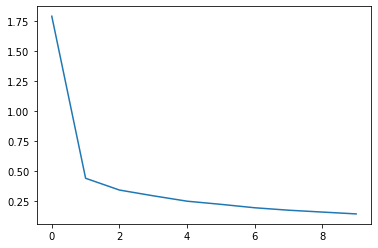

In [33]:
print("Loss curve")
plt.plot(loss_values)

In [34]:
_,_,_,_,out = get_forward_prop(X, w_cnn, w_dense)

In [38]:
print("10 Predicted outputs - " + str(out.argmax(axis = 1)[:10]))
print("10 actual outputs - " + str(Y_encoded.argmax(axis = 1)[:10]))

10 Predicted outputs - [4 3 1 5 0 2 3 1 3 4]
10 actual outputs - [4 3 0 5 0 2 3 1 3 4]


Performance metrics

In [39]:
from sklearn.metrics import classification_report,confusion_matrix
_,_,_,_,out_test = get_forward_prop(X_test, w_cnn, w_dense)
y_pred_class = np.argmax(out_test,axis = 1)
y_test_class = np.argmax(Y_test,axis = 1)
print("Performance Metrics: ")
metrics=classification_report(y_test_class,y_pred_class)
print(metrics)
print("Confusion Matrix: ")
CM=confusion_matrix(y_test_class,y_pred_class)
print(CM)

Performance Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       255
           1       0.96      0.98      0.97       219
           2       0.98      0.96      0.97       178
           3       0.83      0.92      0.87       276
           4       0.91      0.80      0.85       266
           5       1.00      1.00      1.00       277

    accuracy                           0.94      1471
   macro avg       0.94      0.94      0.94      1471
weighted avg       0.94      0.94      0.94      1471

Confusion Matrix: 
[[248   5   2   0   0   0]
 [  2 215   2   0   0   0]
 [  2   5 171   0   0   0]
 [  0   0   0 253  22   1]
 [  0   0   0  53 213   0]
 [  0   0   0   0   0 277]]


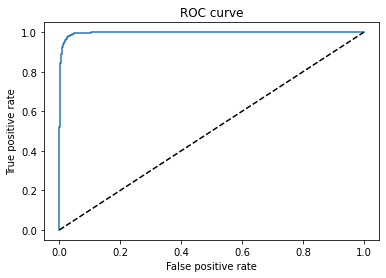

In [40]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(Y_test.ravel(), out_test.ravel())
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Question 1 with keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.utils import shuffle
import tensorflow as tf
from keras import backend as K

tf.config.run_functions_eagerly(True)

In [2]:
X = np.loadtxt(r"C:\Users\user\Desktop\X_train.txt")
Y = (np.loadtxt(r"C:\Users\user\Desktop\Y_train.txt") - 1).astype("int")

In [3]:
activity_dictionary = {0:"WALKING",1:"WALKING_UPSTAIRS",2:"WALKING_DOWNSTAIRS",3:"SITTING",4:"STANDING",5:"LAYING"}

Visualization

Frequency of each activity in dataset


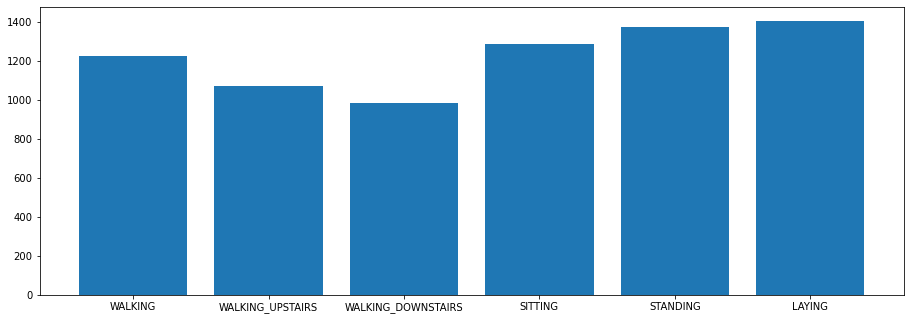

In [4]:
print("Frequency of each activity in dataset")

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
activities = list(activity_dictionary.values())
frequency = [np.sum(Y == i) for i in range(6)]
ax.bar(activities,frequency)
plt.title
plt.show()

Training

In [5]:
X,Y = shuffle(X,Y)

In [6]:
def one_hot(Y, no_of_classes):
    Y_one_hot = np.zeros((len(Y),no_of_classes),dtype = "float")
    for i in range(len(Y)):
        Y_one_hot[i,Y[i]] = 1.
    return Y_one_hot

In [7]:
Y_encoded = one_hot(Y, 6)

In [13]:
X_train = X[:int(0.8*len(X))]
Y_train = Y_encoded[:int(0.8*len(X))]

X_test = X[int(0.8*len(X)):]
Y_test = Y_encoded[int(0.8*len(X)):]

In [50]:
model = keras.Sequential([
    keras.layers.Conv1D(1, 5, activation='relu', padding="same", input_shape=[561,1]),
    keras.layers.AveragePooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation = "softmax")
  ])

In [51]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 561, 1)            6         
_________________________________________________________________
average_pooling1d (AveragePo (None, 280, 1)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 280)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1686      
Total params: 1,692
Trainable params: 1,692
Non-trainable params: 0
_________________________________________________________________


In [52]:
def focal_loss(y_true, y_pred):
    return -tf.math.reduce_sum(tf.math.multiply(y_true,tf.multiply(tf.math.exp(tf.math.subtract(1,y_pred),0.5),tf.math.log(y_pred + 0.00001))),axis = -1)

In [53]:
optimizer = tf.keras.optimizers.SGD(0.01)
model.compile(loss=focal_loss,optimizer=optimizer)

In [54]:
history = model.fit(np.expand_dims(X_train,axis = 2),Y_train,batch_size = 32,epochs = 10)

Epoch 1/10
 11/184 [>.............................] - ETA: 1s - loss: 3.7261

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


184/184 [==============================] - 2s 9ms/step - loss: 1.8655
Epoch 2/10
184/184 [==============================] - 2s 9ms/step - loss: 0.8226
Epoch 3/10
184/184 [==============================] - 2s 9ms/step - loss: 0.5967
Epoch 4/10
184/184 [==============================] - 2s 9ms/step - loss: 0.4844
Epoch 5/10
184/184 [==============================] - 2s 9ms/step - loss: 0.4217
Epoch 6/10
184/184 [==============================] - 2s 9ms/step - loss: 0.3782
Epoch 7/10
184/184 [==============================] - 2s 9ms/step - loss: 0.3421
Epoch 8/10
184/184 [==============================] - 2s 9ms/step - loss: 0.3094
Epoch 9/10
184/184 [==============================] - 2s 9ms/step - loss: 0.2934
Epoch 10/10
184/184 [==============================] - 2s 9ms/step - loss: 0.2616


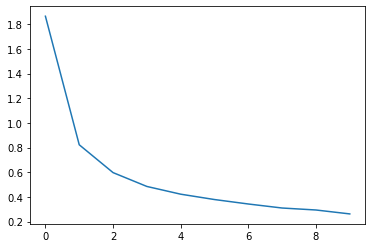

In [55]:
plt.plot(history.history["loss"])

Performance metrics

In [47]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred_class = np.argmax(model.predict(np.expand_dims(X_test,axis = 2)),axis = 1)
y_test_class = np.argmax(Y_test,axis = 1)
print("Performance Metrics: ")
metrics=classification_report(y_test_class,y_pred_class)
print(metrics)
print("Confusion Matrix: ")
CM=confusion_matrix(y_test_class,y_pred_class)
print(CM)

Performance Metrics: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       272
           1       0.99      0.96      0.97       222
           2       0.97      0.98      0.98       205
           3       0.83      0.97      0.89       216
           4       0.97      0.84      0.90       264
           5       1.00      0.99      0.99       292

    accuracy                           0.95      1471
   macro avg       0.95      0.96      0.95      1471
weighted avg       0.96      0.95      0.95      1471

Confusion Matrix: 
[[269   2   1   0   0   0]
 [  5 213   4   0   0   0]
 [  3   1 201   0   0   0]
 [  0   0   0 209   7   0]
 [  0   0   0  41 223   0]
 [  0   0   1   2   0 289]]


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


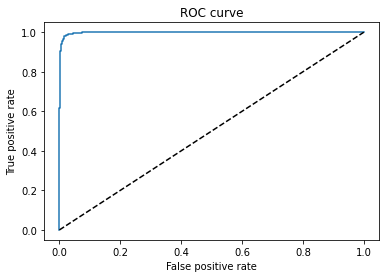

In [48]:
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(np.expand_dims(X_test,axis = 2))
fpr, tpr, threshold = roc_curve(Y_test.ravel(), y_pred.ravel())
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Question 2 binary to octal

In [37]:
import numpy as np
import math
np.random.seed(1)

In [38]:
def bin2oct(bin_list):
    octal = 0
    decimal = 0
    i = 0
    int_val = ""
    for k in bin_list:
        int_val += str(int(k))
    binary = int(int_val)
    
    while(binary != 0):
        decimal += (binary%10) * math.pow(2,i);
        i = i + 1
        binary = int(binary/10)

    i = 1

    while (decimal != 0):
        octal += (decimal % 8) * i;
        decimal = int(decimal/8)
        i *= 10;
    return octal;


def dataset(num):
    # num - no of samples
    bin_len = 8
    X = np.zeros((num, bin_len))
    Y = np.zeros((num))

    for i in range(num):
        X[i] = np.around(np.random.rand(bin_len)).astype(int)
        Y[i] = bin2oct(X[i])
    return X, Y

In [39]:
X , Y = dataset(3)
print(X,Y)

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 1.]] [100. 125. 115.]


In [40]:
no_of_smaples = 20

trainX, trainY = dataset(no_of_smaples)
testX, testY = dataset(5)
print(trainX, trainY, testX, testY)

[[1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]] [304. 355. 322.  20. 262. 176. 113. 345. 324. 326. 334. 336.  17.  72.
 270.  31. 227.  60. 333. 212.] [[0. 1. 0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 1.]] [134. 363. 363. 321. 141.]


In [45]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

#tanh activation
def tanh_activation(X):
    return np.tanh(X)

def softmax(X):
    exp_X = np.exp(X)
    exp_X_sum = np.sum(exp_X,axis=1).reshape(-1,1)
    exp_X = exp_X/exp_X_sum
    return exp_X

def tanh_derivative(X):
    return 1-(X**2)

In [41]:
class lstm:
    def __init__(self):
        self.W = [1, 1]
        self.W_delta = [0.001, 0.001]
        self.W_sign = [0, 0]

        self.eta_p = 1.2
        self.eta_n = 0.5

    def state(self, xk, sk):
        return xk * self.W[0] + sk * self.W[1]

    def forward_states(self, X):
        S = np.zeros((X.shape[0], X.shape[1]+1))
        for k in range(0, X.shape[1]):
            next_state = self.state(X[:,k], S[:,k])
            S[:,k+1] = next_state
        return S

    def output_gradient(self, guess, real):
        return 2 * (guess - real) / no_of_smaples

    def backward_gradient(self, X, S, grad_out):
        grad_over_time = np.zeros(( X.shape[0], X.shape[1]+1 ))
        grad_over_time[:,-1] = grad_out

        wx_grad = 0
        wr_grad = 0
        for k in range(X.shape[1], 0, -1):
            wx_grad += np.sum( grad_over_time[:, k] * X[:, k-1] )
            wr_grad += np.sum( grad_over_time[:, k] * S[:, k-1] )

            grad_over_time[:, k-1] = grad_over_time[:, k] * self.W[1]
        return (wx_grad, wr_grad), grad_over_time

    def update_rprop(self, X, Y, W_prev_sign, W_delta):
        S = self.forward_states(X)
        grad_out =  self.output_gradient(S[:, -1], Y)
        W_grads, _ = self.backward_gradient(X, S, grad_out)
        self.W_sign = np.sign(W_grads)

        for i, _ in enumerate(self.W):
            if self.W_sign[i] == W_prev_sign[i]:
                W_delta[i] *= self.eta_p
            else:
                W_delta[i] *= self.eta_n
        self.W_delta = W_delta

    def train(self, X, Y, training_epochs):
        for epochs in range(training_epochs):
            self.update_rprop(X, Y, self.W_sign, self.W_delta)

            for i, _ in enumerate(self.W):
                self.W[i] -= self.W_sign[i] * self.W_delta[i]

In [42]:
lstm = lstm()
lstm.train(trainX, trainY, 20000)
print("Weight: \t", lstm.W)
print ("Real: \t\t", testY)

y = lstm.forward_states(testX)[:, -1]
print( "Predicted: \t",y)

Weight: 	 [0.9459148394617495, 2.153223711211134]
Real: 		 [134. 363. 363. 321. 141.]
Predicted: 	 [128.4350772  364.36184817 364.36184817 318.5428591  139.00105791]


## Question 3

In [193]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras.models import Model
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\CNN-RNN-Yield-Prediction-master\soybean_samples.csv', sep=',',header=None)

In [3]:
df = np.array(df)

In [4]:
Y = df[1:,np.where(df == "yield")[1][0]].astype("float")

In [157]:
X = np.zeros((len(Y), 6, 52))

for i in range(6):
    for j in range(52):
        string_search = "W_" + str(i + 1) + "_" + str(j + 1)
        X[:,i,j] = df[1:,np.where(df == string_search)[1][0]].astype("float")

In [158]:
mean = X.mean()
std = X.std()

In [159]:
X -= mean
X /= std

In [160]:
X_2016 = np.zeros((len(np.where(df[:,1] == "2016")[0]), 6, 52))

for n,i in enumerate(np.where(df[:,1] == "2016")[0]):
    for j in range(6):
        for k in range(52):
            string_search = "W_" + str(j + 1) + "_" + str(k + 1)
            X_2016[n,j,k] = df[i,np.where(df == string_search)[1][0]]

In [161]:
X_2017 = np.zeros((len(np.where(df[:,1] == "2017")[0]), 6, 52))

for n,i in enumerate(np.where(df[:,1] == "2017")[0]):
    for j in range(6):
        for k in range(52):
            string_search = "W_" + str(j + 1) + "_" + str(k + 1)
            X_2017[n,j,k] = df[i,np.where(df == string_search)[1][0]]

In [162]:
X_2018 = np.zeros((len(np.where(df[:,1] == "2018")[0]), 6, 52))

for n,i in enumerate(np.where(df[:,1] == "2018")[0]):
    for j in range(6):
        for k in range(52):
            string_search = "W_" + str(j + 1) + "_" + str(k + 1)
            X_2018[n,j,k] = df[i,np.where(df == string_search)[1][0]]

In [163]:
X_2016 -= mean
X_2016 /= std

X_2017 -= mean
X_2017 /= std

X_2018 -= mean
X_2018 /= std

In [164]:
Y_2016 = df[np.where(df[:,1] == "2016")[0],2].astype("float")
Y_2017 = df[np.where(df[:,1] == "2017")[0],2].astype("float")
Y_2018 = df[np.where(df[:,1] == "2018")[0],2].astype("float")

1d CNN model

In [165]:
input_dim = Input(shape=(6, 52))

hidden1 = Conv1D(8, 5, activation = "relu", padding="same")(input_dim)
hidden2 = MaxPooling1D(pool_size=2)(hidden1)
hidden3 = Conv1D(16, 5, activation = "relu", padding="same")(hidden2)
hidden4 = MaxPooling1D(pool_size=2)(hidden3)

hidden5 = Flatten()(hidden4)
output = Dense(1)(hidden5)

model_cnn = Model(inputs=input_dim, outputs=output)

In [166]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

In [167]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_cnn.compile(loss=rmse
              ,optimizer=optimizer)

In [168]:
history_cnn = model_cnn.fit(X, Y, batch_size = 32,  epochs = 1000)

Epoch 1/1000
47/47 [==============================] - 0s 1ms/step - loss: 18.4105
Epoch 2/1000
47/47 [==============================] - 0s 1ms/step - loss: 10.2442
Epoch 3/1000
47/47 [==============================] - 0s 1ms/step - loss: 9.6077
Epoch 4/1000
47/47 [==============================] - 0s 1ms/step - loss: 8.6959
Epoch 5/1000
47/47 [==============================] - 0s 1ms/step - loss: 8.1222
Epoch 6/1000
47/47 [==============================] - 0s 1ms/step - loss: 7.2058
Epoch 7/1000
47/47 [==============================] - 0s 1ms/step - loss: 7.6318
Epoch 8/1000
47/47 [==============================] - 0s 985us/step - loss: 6.7941
Epoch 9/1000
47/47 [==============================] - 0s 1ms/step - loss: 6.5556
Epoch 10/1000
47/47 [==============================] - 0s 1ms/step - loss: 6.4060
Epoch 11/1000
47/47 [==============================] - 0s 1ms/step - loss: 6.6732
Epoch 12/1000
47/47 [==============================] - 0s 976us/step - loss: 6.1410
Epoch 13/1000
47/47

47/47 [==============================] - 0s 906us/step - loss: 4.7983
Epoch 195/1000
47/47 [==============================] - 0s 954us/step - loss: 4.4811
Epoch 196/1000
47/47 [==============================] - 0s 964us/step - loss: 4.3886
Epoch 197/1000
47/47 [==============================] - 0s 909us/step - loss: 4.2355
Epoch 198/1000
47/47 [==============================] - 0s 1ms/step - loss: 4.3549
Epoch 199/1000
47/47 [==============================] - 0s 922us/step - loss: 4.2095
Epoch 200/1000
47/47 [==============================] - 0s 901us/step - loss: 4.3237
Epoch 201/1000
47/47 [==============================] - 0s 963us/step - loss: 4.6322
Epoch 202/1000
47/47 [==============================] - 0s 902us/step - loss: 4.3378
Epoch 203/1000
47/47 [==============================] - 0s 914us/step - loss: 4.4726
Epoch 204/1000
47/47 [==============================] - 0s 1ms/step - loss: 4.5007
Epoch 205/1000
47/47 [==============================] - 0s 947us/step - loss: 4.3098

47/47 [==============================] - 0s 954us/step - loss: 3.9074
Epoch 387/1000
47/47 [==============================] - 0s 976us/step - loss: 3.9762
Epoch 388/1000
47/47 [==============================] - 0s 917us/step - loss: 3.9218
Epoch 389/1000
47/47 [==============================] - 0s 912us/step - loss: 4.2189
Epoch 390/1000
47/47 [==============================] - 0s 971us/step - loss: 3.8765
Epoch 391/1000
47/47 [==============================] - 0s 906us/step - loss: 4.0594
Epoch 392/1000
47/47 [==============================] - 0s 958us/step - loss: 4.0570
Epoch 393/1000
47/47 [==============================] - 0s 976us/step - loss: 3.9505
Epoch 394/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.8365
Epoch 395/1000
47/47 [==============================] - 0s 923us/step - loss: 4.0329
Epoch 396/1000
47/47 [==============================] - 0s 905us/step - loss: 4.0192
Epoch 397/1000
47/47 [==============================] - 0s 966us/step - loss: 4.25

47/47 [==============================] - 0s 908us/step - loss: 3.6622
Epoch 579/1000
47/47 [==============================] - 0s 996us/step - loss: 3.7124
Epoch 580/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.6070
Epoch 581/1000
47/47 [==============================] - 0s 954us/step - loss: 3.6099
Epoch 582/1000
47/47 [==============================] - 0s 899us/step - loss: 3.5812
Epoch 583/1000
47/47 [==============================] - 0s 936us/step - loss: 3.6448
Epoch 584/1000
47/47 [==============================] - 0s 966us/step - loss: 3.7314
Epoch 585/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.6786
Epoch 586/1000
47/47 [==============================] - 0s 920us/step - loss: 3.5233
Epoch 587/1000
47/47 [==============================] - 0s 917us/step - loss: 3.5773
Epoch 588/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.8580
Epoch 589/1000
47/47 [==============================] - 0s 976us/step - loss: 3.4780
E

47/47 [==============================] - 0s 980us/step - loss: 3.4859
Epoch 771/1000
47/47 [==============================] - 0s 956us/step - loss: 3.4995
Epoch 772/1000
47/47 [==============================] - 0s 923us/step - loss: 3.3651
Epoch 773/1000
47/47 [==============================] - 0s 919us/step - loss: 3.3922
Epoch 774/1000
47/47 [==============================] - 0s 961us/step - loss: 3.4539
Epoch 775/1000
47/47 [==============================] - 0s 905us/step - loss: 3.4059
Epoch 776/1000
47/47 [==============================] - 0s 892us/step - loss: 3.4234
Epoch 777/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.3335
Epoch 778/1000
47/47 [==============================] - 0s 947us/step - loss: 3.3520
Epoch 779/1000
47/47 [==============================] - 0s 919us/step - loss: 3.3490
Epoch 780/1000
47/47 [==============================] - 0s 912us/step - loss: 3.3177
Epoch 781/1000
47/47 [==============================] - 0s 976us/step - loss: 3.35

47/47 [==============================] - 0s 1ms/step - loss: 3.1969
Epoch 963/1000
47/47 [==============================] - 0s 968us/step - loss: 3.1617
Epoch 964/1000
47/47 [==============================] - 0s 954us/step - loss: 3.2327
Epoch 965/1000
47/47 [==============================] - 0s 916us/step - loss: 3.3416
Epoch 966/1000
47/47 [==============================] - 0s 930us/step - loss: 3.3020
Epoch 967/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.2354
Epoch 968/1000
47/47 [==============================] - 0s 936us/step - loss: 3.4234
Epoch 969/1000
47/47 [==============================] - 0s 976us/step - loss: 3.1871
Epoch 970/1000
47/47 [==============================] - 0s 900us/step - loss: 3.2164
Epoch 971/1000
47/47 [==============================] - 0s 910us/step - loss: 3.3834
Epoch 972/1000
47/47 [==============================] - 0s 953us/step - loss: 3.4167
Epoch 973/1000
47/47 [==============================] - 0s 948us/step - loss: 3.3426

LSTM model

In [169]:
input_dim = Input(shape=(6, 52))

hidden1 = LSTM(8, activation = "relu")(input_dim)
output = Dense(1)(hidden1)

model_lstm = Model(inputs=input_dim, outputs=output)

In [170]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_lstm.compile(loss=rmse
              ,optimizer=optimizer)

In [171]:
history_lstm = model_lstm.fit(X, Y, batch_size = 32, epochs = 1000)

Epoch 1/1000
47/47 [==============================] - 1s 2ms/step - loss: 19.4527
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.9374
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.8458
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.2225
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 7.6481
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 7.6564
Epoch 7/1000
47/47 [==============================] - 0s 2ms/step - loss: 6.8026
Epoch 8/1000
47/47 [==============================] - 0s 2ms/step - loss: 6.4863
Epoch 9/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.7619
Epoch 10/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.8212
Epoch 11/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.5241
Epoch 12/1000
47/47 [==============================] - 0s 1ms/step - loss: 5.5117
Epoch 13/1000
47/47 [==

Epoch 101/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.4847
Epoch 102/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3155
Epoch 103/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3728
Epoch 104/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3813
Epoch 105/1000
47/47 [==============================] - 0s 1ms/step - loss: 4.3301
Epoch 106/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3396
Epoch 107/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3304
Epoch 108/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3261
Epoch 109/1000
47/47 [==============================] - 0s 1ms/step - loss: 4.3930
Epoch 110/1000
47/47 [==============================] - 0s 1ms/step - loss: 4.2465
Epoch 111/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.2849
Epoch 112/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.2853
Epoc

47/47 [==============================] - 0s 2ms/step - loss: 3.6727
Epoch 298/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.6443
Epoch 299/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.5846
Epoch 300/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.6601
Epoch 301/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.5122
Epoch 302/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.5212
Epoch 303/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.6274
Epoch 304/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.5290
Epoch 305/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4769
Epoch 306/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.5055
Epoch 307/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4687
Epoch 308/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.5904
Epoch 309/1000
47/4

47/47 [==============================] - 0s 2ms/step - loss: 3.1217
Epoch 494/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.2729
Epoch 495/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1932
Epoch 496/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0955
Epoch 497/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.2831
Epoch 498/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1456
Epoch 499/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.3037
Epoch 500/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.3153
Epoch 501/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.3097
Epoch 502/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.3327
Epoch 503/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1358
Epoch 504/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1974
Epoch 505/1000
47/4

47/47 [==============================] - 0s 2ms/step - loss: 3.0748
Epoch 690/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.9844
Epoch 691/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0215
Epoch 692/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.0694
Epoch 693/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.9902
Epoch 694/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0763
Epoch 695/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0008
Epoch 696/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.0443
Epoch 697/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1436
Epoch 698/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0875
Epoch 699/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0022
Epoch 700/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0104
Epoch 701/1000
47/4

47/47 [==============================] - 0s 2ms/step - loss: 2.9382
Epoch 886/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.9428
Epoch 887/1000
47/47 [==============================] - 0s 1ms/step - loss: 2.9675
Epoch 888/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.8920
Epoch 889/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1029
Epoch 890/1000
47/47 [==============================] - 0s 1ms/step - loss: 2.9984
Epoch 891/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0369
Epoch 892/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.9350
Epoch 893/1000
47/47 [==============================] - 0s 1ms/step - loss: 2.8734
Epoch 894/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.8841
Epoch 895/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.9926
Epoch 896/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.9507
Epoch 897/1000
47/4

CNN LSTM model

In [214]:
input_dim = Input(shape=(6, 52))

hidden1 = Conv1D(8, 5, activation = "relu", padding="same")(input_dim)
hidden2 = MaxPooling1D(pool_size=2)(hidden1)
hidden3 = Conv1D(16, 5, activation = "relu", padding="same")(hidden2)
hidden4 = MaxPooling1D(pool_size=2)(hidden3)

hidden6 = LSTM(8, activation = "relu")(hidden4)
output = Dense(1)(hidden6)

model_cnn_lstm = Model(inputs=input_dim, outputs=output)

In [215]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_cnn_lstm.compile(loss=rmse
              ,optimizer=optimizer)

In [216]:
history_cnn_lstm = model_cnn_lstm.fit(X, Y, batch_size = 32, epochs = 1000)

Epoch 1/1000
47/47 [==============================] - 1s 2ms/step - loss: 15.2964
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.7476
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.1491
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 8.1894
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 7.0947
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 7.8253
Epoch 7/1000
47/47 [==============================] - 0s 2ms/step - loss: 6.7103
Epoch 8/1000
47/47 [==============================] - 0s 2ms/step - loss: 6.3326
Epoch 9/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.8415
Epoch 10/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.7592
Epoch 11/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.7722
Epoch 12/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.8252
Epoch 13/1000
47/47 [===

Epoch 101/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.5904
Epoch 102/1000
47/47 [==============================] - 0s 2ms/step - loss: 5.0103
Epoch 103/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.7676
Epoch 104/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.6572
Epoch 105/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.6977
Epoch 106/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.6716
Epoch 107/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.4809
Epoch 108/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.9557
Epoch 109/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.9270
Epoch 110/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.5416
Epoch 111/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.6674
Epoch 112/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.6984
Epoc

47/47 [==============================] - 0s 2ms/step - loss: 3.9347
Epoch 298/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.0345
Epoch 299/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.1892
Epoch 300/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.9521
Epoch 301/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.1048
Epoch 302/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3200
Epoch 303/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.9400
Epoch 304/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.9725
Epoch 305/1000
47/47 [==============================] - 0s 1ms/step - loss: 4.1609
Epoch 306/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.2262
Epoch 307/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.1225
Epoch 308/1000
47/47 [==============================] - 0s 2ms/step - loss: 4.3946
Epoch 309/1000
47/4

47/47 [==============================] - 0s 2ms/step - loss: 3.5033
Epoch 494/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.3757
Epoch 495/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4478
Epoch 496/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.6164
Epoch 497/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.6296
Epoch 498/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.6120
Epoch 499/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.5569
Epoch 500/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4318
Epoch 501/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.5290
Epoch 502/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4967
Epoch 503/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4549
Epoch 504/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4422
Epoch 505/1000
47/4

47/47 [==============================] - 0s 2ms/step - loss: 3.4792
Epoch 690/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.3705
Epoch 691/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4033
Epoch 692/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.2063
Epoch 693/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.2498
Epoch 694/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.2193
Epoch 695/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.2712
Epoch 696/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.2330
Epoch 697/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.3576
Epoch 698/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1352
Epoch 699/1000
47/47 [==============================] - 0s 1ms/step - loss: 3.2811
Epoch 700/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.4482
Epoch 701/1000
47/4

47/47 [==============================] - 0s 2ms/step - loss: 3.0566
Epoch 886/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1621
Epoch 887/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1389
Epoch 888/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1271
Epoch 889/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.3116
Epoch 890/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0795
Epoch 891/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1971
Epoch 892/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1942
Epoch 893/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0723
Epoch 894/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0881
Epoch 895/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1170A: 0s - loss: 3.111
Epoch 896/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.1617


Loss comparisons

CNN model


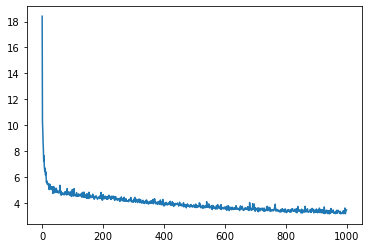

In [217]:
print("CNN model")
plt.plot(history_cnn.history["loss"])

LSTM model


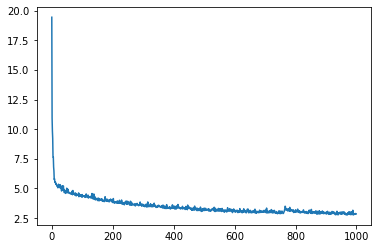

In [218]:
print("LSTM model")
plt.plot(history_lstm.history["loss"])

CNN LSTM model


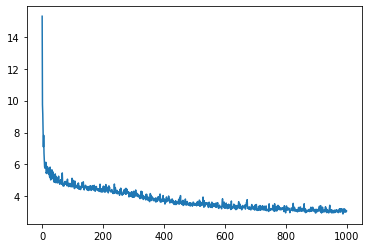

In [219]:
print("CNN LSTM model")
plt.plot(history_cnn_lstm.history["loss"])

Performance

In [220]:
print("2016")
print("RMSE CNN - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn.predict(X_2016)).flatten() - Y_2016)))))
print("RMSE LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_lstm.predict(X_2016)).flatten() - Y_2016)))))
print("RMSE CNN LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn_lstm.predict(X_2016)).flatten() - Y_2016)))))
print("Correlation coefficient CNN - " + str(pearsonr(np.array(model_cnn.predict(X_2016)).flatten(), Y_2016)[0]))
print("Correlation coefficient LSTM - " + str(pearsonr(np.array(model_lstm.predict(X_2016)).flatten(), Y_2016)[0]))
print("Correlation coefficient CNN LSTM - " + str(pearsonr(np.array(model_cnn_lstm.predict(X_2016)).flatten(), Y_2016)[0]))

2016
RMSE CNN - 2.913068568925
RMSE LSTM - 4.335713880688425
RMSE CNN LSTM - 3.14362030396437
Correlation coefficient CNN - 0.9183732169565855
Correlation coefficient LSTM - 0.8948639788751406
Correlation coefficient CNN LSTM - 0.9102423247673707


In [221]:
print("2017")
print("RMSE CNN - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn.predict(X_2017)).flatten() - Y_2017)))))
print("RMSE LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_lstm.predict(X_2017)).flatten() - Y_2017)))))
print("RMSE CNN LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn_lstm.predict(X_2017)).flatten() - Y_2017)))))
print("Correlation coefficient CNN - " + str(pearsonr(np.array(model_cnn.predict(X_2017)).flatten(), Y_2017)[0]))
print("Correlation coefficient LSTM - " + str(pearsonr(np.array(model_lstm.predict(X_2017)).flatten(), Y_2017)[0]))
print("Correlation coefficient CNN LSTM - " + str(pearsonr(np.array(model_cnn_lstm.predict(X_2017)).flatten(), Y_2017)[0]))

2017
RMSE CNN - 3.5999675173057075
RMSE LSTM - 3.825111267326197
RMSE CNN LSTM - 3.7992801014054125
Correlation coefficient CNN - 0.8460425188505177
Correlation coefficient LSTM - 0.8656714368380263
Correlation coefficient CNN LSTM - 0.8485449558591855


In [222]:
print("2018")
print("RMSE CNN - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn.predict(X_2018)).flatten() - Y_2018)))))
print("RMSE LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_lstm.predict(X_2018)).flatten() - Y_2018)))))
print("RMSE CNN LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn_lstm.predict(X_2018)).flatten() - Y_2018)))))
print("Correlation coefficient CNN - " + str(pearsonr(np.array(model_cnn.predict(X_2018)).flatten(), Y_2018)[0]))
print("Correlation coefficient LSTM - " + str(pearsonr(np.array(model_lstm.predict(X_2018)).flatten(), Y_2018)[0]))
print("Correlation coefficient CNN LSTM - " + str(pearsonr(np.array(model_cnn_lstm.predict(X_2018)).flatten(), Y_2018)[0]))

2018
RMSE CNN - 4.3140272087659
RMSE LSTM - 3.784433822590537
RMSE CNN LSTM - 4.23471505978333
Correlation coefficient CNN - 0.892295498219539
Correlation coefficient LSTM - 0.9354579491956603
Correlation coefficient CNN LSTM - 0.9202891488017144


## Q3 with different dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras.models import Model
from scipy.stats import pearsonr

In [3]:
df = pd.read_csv(r'C:\Users\user\Desktop\CNN-RNN-Yield-Prediction-master\corn_samples.csv', sep=',',header=None)

In [4]:
df = np.array(df)

In [5]:
Y = df[1:,np.where(df == "yield")[1][0]].astype("float")

In [6]:
X = np.zeros((len(Y), 6, 52))

for i in range(6):
    for j in range(52):
        string_search = "W_" + str(i + 1) + "_" + str(j + 1)
        X[:,i,j] = df[1:,np.where(df == string_search)[1][0]].astype("float")

In [7]:
mean = X.mean()
std = X.std()

In [8]:
X -= mean
X /= std

In [9]:
X_2016 = np.zeros((len(np.where(df[:,1] == "2016")[0]), 6, 52))

for n,i in enumerate(np.where(df[:,1] == "2016")[0]):
    for j in range(6):
        for k in range(52):
            string_search = "W_" + str(j + 1) + "_" + str(k + 1)
            X_2016[n,j,k] = df[i,np.where(df == string_search)[1][0]]

In [10]:
X_2017 = np.zeros((len(np.where(df[:,1] == "2017")[0]), 6, 52))

for n,i in enumerate(np.where(df[:,1] == "2017")[0]):
    for j in range(6):
        for k in range(52):
            string_search = "W_" + str(j + 1) + "_" + str(k + 1)
            X_2017[n,j,k] = df[i,np.where(df == string_search)[1][0]]

In [11]:
X_2018 = np.zeros((len(np.where(df[:,1] == "2018")[0]), 6, 52))

for n,i in enumerate(np.where(df[:,1] == "2018")[0]):
    for j in range(6):
        for k in range(52):
            string_search = "W_" + str(j + 1) + "_" + str(k + 1)
            X_2018[n,j,k] = df[i,np.where(df == string_search)[1][0]]

In [12]:
X_2016 -= mean
X_2016 /= std

X_2017 -= mean
X_2017 /= std

X_2018 -= mean
X_2018 /= std

In [13]:
Y_2016 = df[np.where(df[:,1] == "2016")[0],2].astype("float")
Y_2017 = df[np.where(df[:,1] == "2017")[0],2].astype("float")
Y_2018 = df[np.where(df[:,1] == "2018")[0],2].astype("float")

1d CNN model

In [14]:
input_dim = Input(shape=(6, 52))

hidden1 = Conv1D(8, 5, activation = "relu", padding="same")(input_dim)
hidden2 = MaxPooling1D(pool_size=2)(hidden1)
hidden3 = Conv1D(16, 5, activation = "relu", padding="same")(hidden2)
hidden4 = MaxPooling1D(pool_size=2)(hidden3)

hidden5 = Flatten()(hidden4)
output = Dense(1)(hidden5)

model_cnn = Model(inputs=input_dim, outputs=output)

In [15]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

In [16]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_cnn.compile(loss=rmse
              ,optimizer=optimizer)

In [17]:
history_cnn = model_cnn.fit(X, Y, batch_size = 32,  epochs = 1000)

Epoch 1/1000
47/47 [==============================] - 1s 1ms/step - loss: 61.9184
Epoch 2/1000
47/47 [==============================] - 0s 1ms/step - loss: 37.6596
Epoch 3/1000
47/47 [==============================] - 0s 1ms/step - loss: 36.4921
Epoch 4/1000
47/47 [==============================] - 0s 1ms/step - loss: 33.7916
Epoch 5/1000
47/47 [==============================] - 0s 1ms/step - loss: 31.7102
Epoch 6/1000
47/47 [==============================] - 0s 981us/step - loss: 28.9273
Epoch 7/1000
47/47 [==============================] - 0s 1ms/step - loss: 27.6287
Epoch 8/1000
47/47 [==============================] - 0s 1ms/step - loss: 25.8038
Epoch 9/1000
47/47 [==============================] - 0s 1ms/step - loss: 24.6616
Epoch 10/1000
47/47 [==============================] - 0s 1ms/step - loss: 23.7980
Epoch 11/1000
47/47 [==============================] - 0s 981us/step - loss: 23.2300
Epoch 12/1000
47/47 [==============================] - 0s 1ms/step - loss: 22.6097
Epoch 13/

47/47 [==============================] - 0s 1ms/step - loss: 15.3812
Epoch 197/1000
47/47 [==============================] - 0s 970us/step - loss: 15.3073
Epoch 198/1000
47/47 [==============================] - 0s 1ms/step - loss: 15.0543
Epoch 199/1000
47/47 [==============================] - 0s 1ms/step - loss: 15.4301
Epoch 200/1000
47/47 [==============================] - 0s 961us/step - loss: 16.2391
Epoch 201/1000
47/47 [==============================] - 0s 963us/step - loss: 15.4337
Epoch 202/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.8676
Epoch 203/1000
47/47 [==============================] - 0s 932us/step - loss: 14.9872
Epoch 204/1000
47/47 [==============================] - 0s 1ms/step - loss: 15.3548
Epoch 205/1000
47/47 [==============================] - 0s 993us/step - loss: 15.2124
Epoch 206/1000
47/47 [==============================] - 0s 1ms/step - loss: 16.0588
Epoch 207/1000
47/47 [==============================] - 0s 1ms/step - loss: 15.17

47/47 [==============================] - 0s 1ms/step - loss: 14.0038
Epoch 391/1000
47/47 [==============================] - 0s 986us/step - loss: 13.9606
Epoch 392/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.6049
Epoch 393/1000
47/47 [==============================] - 0s 948us/step - loss: 14.1943
Epoch 394/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.6073
Epoch 395/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.3165
Epoch 396/1000
47/47 [==============================] - 0s 995us/step - loss: 13.8218
Epoch 397/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.3734
Epoch 398/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.2197
Epoch 399/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.3540
Epoch 400/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.2806
Epoch 401/1000
47/47 [==============================] - 0s 1ms/step - loss: 14.2258
E

47/47 [==============================] - 0s 1ms/step - loss: 13.3524
Epoch 585/1000
47/47 [==============================] - 0s 993us/step - loss: 13.5844
Epoch 586/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.6110
Epoch 587/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.4202
Epoch 588/1000
47/47 [==============================] - 0s 911us/step - loss: 13.1684
Epoch 589/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.9729
Epoch 590/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.3419
Epoch 591/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.2862
Epoch 592/1000
47/47 [==============================] - 0s 995us/step - loss: 13.8008
Epoch 593/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.5458
Epoch 594/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.0809
Epoch 595/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.4213
E

47/47 [==============================] - 0s 1ms/step - loss: 12.9239
Epoch 682/1000
47/47 [==============================] - 0s 959us/step - loss: 13.0262
Epoch 683/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.7606
Epoch 684/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.9292
Epoch 685/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.3788
Epoch 686/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.1362
Epoch 687/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.8261
Epoch 688/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.3598
Epoch 689/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.1725
Epoch 690/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.8353
Epoch 691/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.0829
Epoch 692/1000
47/47 [==============================] - 0s 951us/step - loss: 13.0183
Epo

47/47 [==============================] - 0s 1ms/step - loss: 11.9938
Epoch 876/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.6869
Epoch 877/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.6345
Epoch 878/1000
47/47 [==============================] - 0s 1ms/step - loss: 11.9182
Epoch 879/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.1164
Epoch 880/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.0432
Epoch 881/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.3414
Epoch 882/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.3732
Epoch 883/1000
47/47 [==============================] - 0s 1ms/step - loss: 11.8409
Epoch 884/1000
47/47 [==============================] - 0s 1ms/step - loss: 11.9537
Epoch 885/1000
47/47 [==============================] - 0s 1ms/step - loss: 11.7752
Epoch 886/1000
47/47 [==============================] - 0s 1ms/step - loss: 12.3689
Epoch 8

LSTM model

In [18]:
input_dim = Input(shape=(6, 52))

hidden1 = LSTM(8, activation = "relu")(input_dim)
output = Dense(1)(hidden1)

model_lstm = Model(inputs=input_dim, outputs=output)

In [19]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_lstm.compile(loss=rmse
              ,optimizer=optimizer)

In [20]:
history_lstm = model_lstm.fit(X, Y, batch_size = 32, epochs = 1000)

Epoch 1/1000
47/47 [==============================] - 1s 2ms/step - loss: 60.1328
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 36.7968
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 36.4621
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 34.3328
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 31.9557
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 30.2996
Epoch 7/1000
47/47 [==============================] - 0s 2ms/step - loss: 28.5033
Epoch 8/1000
47/47 [==============================] - 0s 2ms/step - loss: 26.3085
Epoch 9/1000
47/47 [==============================] - 0s 2ms/step - loss: 26.2567
Epoch 10/1000
47/47 [==============================] - 0s 2ms/step - loss: 25.2554
Epoch 11/1000
47/47 [==============================] - 0s 2ms/step - loss: 24.7087
Epoch 12/1000
47/47 [==============================] - 0s 2ms/step - loss: 24.8625
Epoch 13/1000

47/47 [==============================] - 0s 3ms/step - loss: 14.2161
Epoch 197/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.5405
Epoch 198/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.8611
Epoch 199/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.0627
Epoch 200/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.2973
Epoch 201/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.5820
Epoch 202/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.1218
Epoch 203/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.8461
Epoch 204/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.4116
Epoch 205/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.7198
Epoch 206/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.8773
Epoch 207/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.6495
Epoch 2

47/47 [==============================] - 0s 2ms/step - loss: 11.6140
Epoch 391/1000
47/47 [==============================] - 0s 2ms/step - loss: 12.0454
Epoch 392/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.8861
Epoch 393/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.5399
Epoch 394/1000
47/47 [==============================] - 0s 2ms/step - loss: 12.0321
Epoch 395/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.6085
Epoch 396/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.9563
Epoch 397/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.8916
Epoch 398/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.9752
Epoch 399/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.7255
Epoch 400/1000
47/47 [==============================] - 0s 2ms/step - loss: 12.0496
Epoch 401/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.8755
Epoch 4

47/47 [==============================] - 0s 2ms/step - loss: 11.2607
Epoch 488/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.5300
Epoch 489/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.3272
Epoch 490/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.4810
Epoch 491/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.2723
Epoch 492/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.6670
Epoch 493/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.8318
Epoch 494/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.7147
Epoch 495/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.5209
Epoch 496/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.2673
Epoch 497/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.5389
Epoch 498/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.2997
Epoch 4

47/47 [==============================] - 0s 2ms/step - loss: 11.5619
Epoch 682/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.3165
Epoch 683/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.5542
Epoch 684/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.7424
Epoch 685/1000
47/47 [==============================] - ETA: 0s - loss: 12.23 - 0s 2ms/step - loss: 11.8094
Epoch 686/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.1614
Epoch 687/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.0875
Epoch 688/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.1419
Epoch 689/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.2097
Epoch 690/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.3847
Epoch 691/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.9373
Epoch 692/1000
47/47 [==============================] - 0s 2ms/step

47/47 [==============================] - 0s 2ms/step - loss: 11.5808
Epoch 779/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.7171
Epoch 780/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.3251
Epoch 781/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.0179
Epoch 782/1000
47/47 [==============================] - 0s 2ms/step - loss: 11.0029
Epoch 783/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.4689
Epoch 784/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.2129
Epoch 785/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.2924
Epoch 786/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.0650
Epoch 787/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.3940
Epoch 788/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.3633
Epoch 789/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.2141
Epoch 7

47/47 [==============================] - 0s 2ms/step - loss: 10.2646
Epoch 974/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.8549
Epoch 975/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.1306
Epoch 976/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.9425
Epoch 977/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.9567
Epoch 978/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.6965
Epoch 979/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.6567
Epoch 980/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.3298
Epoch 981/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.7818
Epoch 982/1000
47/47 [==============================] - 0s 2ms/step - loss: 9.9285
Epoch 983/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.2547
Epoch 984/1000
47/47 [==============================] - 0s 2ms/step - loss: 10.4889
Epoch 985/1000

CNN LSTM model

In [31]:
input_dim = Input(shape=(6, 52))

hidden1 = Conv1D(8, 5, activation = "relu", padding="same")(input_dim)
hidden2 = MaxPooling1D(pool_size=2)(hidden1)
hidden3 = Conv1D(16, 5, activation = "relu", padding="same")(hidden2)
hidden4 = MaxPooling1D(pool_size=2)(hidden3)

hidden6 = LSTM(8, activation = "relu")(hidden4)
output = Dense(1)(hidden6)

model_cnn_lstm = Model(inputs=input_dim, outputs=output)

In [32]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_cnn_lstm.compile(loss=rmse
              ,optimizer=optimizer)

In [33]:
history_cnn_lstm = model_cnn_lstm.fit(X, Y, batch_size = 32, epochs = 1000)

Epoch 1/1000
47/47 [==============================] - 1s 2ms/step - loss: 76.1635
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 38.9959
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 37.3201
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 35.7319
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 33.4138
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 30.4246
Epoch 7/1000
47/47 [==============================] - 0s 2ms/step - loss: 27.6552
Epoch 8/1000
47/47 [==============================] - 0s 2ms/step - loss: 26.1250
Epoch 9/1000
47/47 [==============================] - 0s 2ms/step - loss: 24.3260
Epoch 10/1000
47/47 [==============================] - 0s 2ms/step - loss: 23.4729
Epoch 11/1000
47/47 [==============================] - 0s 2ms/step - loss: 22.0836
Epoch 12/1000
47/47 [==============================] - 0s 2ms/step - loss: 22.6512
Epoch 13/1000

47/47 [==============================] - 0s 2ms/step - loss: 15.5494
Epoch 197/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.6789
Epoch 198/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.3259
Epoch 199/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.9541
Epoch 200/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.3097
Epoch 201/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.9236
Epoch 202/1000
47/47 [==============================] - 0s 2ms/step - loss: 16.1296
Epoch 203/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.4497
Epoch 204/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.1722
Epoch 205/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.1770
Epoch 206/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.3864
Epoch 207/1000
47/47 [==============================] - 0s 2ms/step - loss: 16.0068
Epoch 2

47/47 [==============================] - 0s 2ms/step - loss: 14.7501
Epoch 391/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.6409
Epoch 392/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.3832
Epoch 393/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.6030
Epoch 394/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.7292
Epoch 395/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.0018
Epoch 396/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.8340
Epoch 397/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.6652
Epoch 398/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.6247
Epoch 399/1000
47/47 [==============================] - 0s 2ms/step - loss: 15.1654
Epoch 400/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.3515
Epoch 401/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.5724
Epoch 4

47/47 [==============================] - 0s 2ms/step - loss: 14.2290
Epoch 585/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.2966
Epoch 586/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.9924
Epoch 587/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.9690
Epoch 588/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.0782
Epoch 589/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.0647
Epoch 590/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.9151
Epoch 591/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.5147
Epoch 592/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.1774
Epoch 593/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.1727
Epoch 594/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.3062
Epoch 595/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.7887
Epoch 5

47/47 [==============================] - 0s 2ms/step - loss: 14.0345
Epoch 682/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.7772
Epoch 683/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.8547
Epoch 684/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.7282
Epoch 685/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.0812
Epoch 686/1000
47/47 [==============================] - 0s 1ms/step - loss: 13.4830
Epoch 687/1000
47/47 [==============================] - 0s 2ms/step - loss: 14.1023
Epoch 688/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.4910
Epoch 689/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.6397
Epoch 690/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.6759
Epoch 691/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.8054
Epoch 692/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.5193
Epoch 6

47/47 [==============================] - 0s 2ms/step - loss: 14.1912
Epoch 876/1000
47/47 [==============================] - 0s 2ms/step - loss: 12.6718
Epoch 877/1000
47/47 [==============================] - 0s 2ms/step - loss: 12.7719
Epoch 878/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.2984
Epoch 879/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.7788
Epoch 880/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.0478
Epoch 881/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.6546
Epoch 882/1000
47/47 [==============================] - ETA: 0s - loss: 12.77 - 0s 2ms/step - loss: 12.9050
Epoch 883/1000
47/47 [==============================] - ETA: 0s - loss: 13.17 - 0s 2ms/step - loss: 13.1954
Epoch 884/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.1111
Epoch 885/1000
47/47 [==============================] - 0s 2ms/step - loss: 13.3365
Epoch 886/1000
47/47 [=====================

Loss comparisons

CNN model


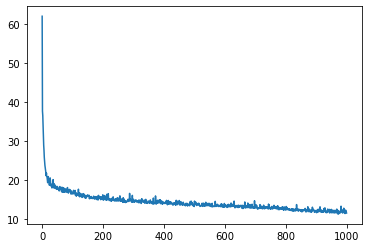

In [34]:
print("CNN model")
plt.plot(history_cnn.history["loss"])

LSTM model


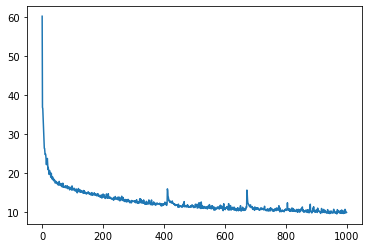

In [35]:
print("LSTM model")
plt.plot(history_lstm.history["loss"])

CNN LSTM model


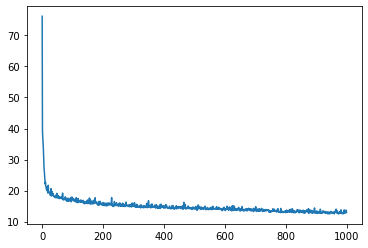

In [36]:
print("CNN LSTM model")
plt.plot(history_cnn_lstm.history["loss"])

Performance

In [37]:
print("2016")
print("RMSE CNN - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn.predict(X_2016)).flatten() - Y_2016)))))
print("RMSE LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_lstm.predict(X_2016)).flatten() - Y_2016)))))
print("RMSE CNN LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn_lstm.predict(X_2016)).flatten() - Y_2016)))))
print("Correlation coefficient CNN - " + str(pearsonr(np.array(model_cnn.predict(X_2016)).flatten(), Y_2016)[0]))
print("Correlation coefficient LSTM - " + str(pearsonr(np.array(model_lstm.predict(X_2016)).flatten(), Y_2016)[0]))
print("Correlation coefficient CNN LSTM - " + str(pearsonr(np.array(model_cnn_lstm.predict(X_2016)).flatten(), Y_2016)[0]))

2016
RMSE CNN - 10.303946803344195
RMSE LSTM - 10.411912448819411
RMSE CNN LSTM - 14.329437037854222
Correlation coefficient CNN - 0.942438016466505
Correlation coefficient LSTM - 0.9455100156512037
Correlation coefficient CNN LSTM - 0.8936883453574173


In [38]:
print("2017")
print("RMSE CNN - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn.predict(X_2017)).flatten() - Y_2017)))))
print("RMSE LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_lstm.predict(X_2017)).flatten() - Y_2017)))))
print("RMSE CNN LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn_lstm.predict(X_2017)).flatten() - Y_2017)))))
print("Correlation coefficient CNN - " + str(pearsonr(np.array(model_cnn.predict(X_2017)).flatten(), Y_2017)[0]))
print("Correlation coefficient LSTM - " + str(pearsonr(np.array(model_lstm.predict(X_2017)).flatten(), Y_2017)[0]))
print("Correlation coefficient CNN LSTM - " + str(pearsonr(np.array(model_cnn_lstm.predict(X_2017)).flatten(), Y_2017)[0]))

2017
RMSE CNN - 15.929372360504622
RMSE LSTM - 12.161325578870771
RMSE CNN LSTM - 16.53305525410175
Correlation coefficient CNN - 0.830804963975925
Correlation coefficient LSTM - 0.8859377228941335
Correlation coefficient CNN LSTM - 0.7993187379559267


In [39]:
print("2018")
print("RMSE CNN - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn.predict(X_2018)).flatten() - Y_2018)))))
print("RMSE LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_lstm.predict(X_2018)).flatten() - Y_2018)))))
print("RMSE CNN LSTM - " + str(np.sqrt(np.mean(np.square(np.array(model_cnn_lstm.predict(X_2018)).flatten() - Y_2018)))))
print("Correlation coefficient CNN - " + str(pearsonr(np.array(model_cnn.predict(X_2018)).flatten(), Y_2018)[0]))
print("Correlation coefficient LSTM - " + str(pearsonr(np.array(model_lstm.predict(X_2018)).flatten(), Y_2018)[0]))
print("Correlation coefficient CNN LSTM - " + str(pearsonr(np.array(model_cnn_lstm.predict(X_2018)).flatten(), Y_2018)[0]))

2018
RMSE CNN - 10.892299269090847
RMSE LSTM - 7.994459331327129
RMSE CNN LSTM - 12.99589864994334
Correlation coefficient CNN - 0.8928965487513085
Correlation coefficient LSTM - 0.9497286822247671
Correlation coefficient CNN LSTM - 0.8530708401558476


## Question 4 binary to decimal

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [115]:
no_of_bits = 4

In [116]:
def pad_to_n_bits(bit_list, number_of_bits):
    int_converted_list = [int(i) for i in bit_list]
    return [0]*(number_of_bits - len(int_converted_list)) + int_converted_list

In [117]:
def create_dataset(number_of_bits):
    
    X = np.array([pad_to_n_bits(list(bin(i)[2:]), number_of_bits) for i in range(np.power(2,number_of_bits))])
    
    Y = np.arange(np.power(2,number_of_bits))
    
    return X,Y

In [118]:
X,Y = create_dataset(no_of_bits)
X,Y = shuffle(X,Y)

In [119]:
def sigmoid(X):
    return 1/(1 + np.exp(-X))

In [120]:
def tanh(X):
    return (1 - np.exp(-2*X))/(1 + np.exp(-2*X))

In [121]:
def mse_loss_total(y_pred, y):
    return np.mean(np.square(y_pred - y))

In [122]:
def relu(X):
    return (X>0)*X

In [123]:
def forward_prop_all(weights, h_init, X):
    
    h = np.array(list(h_init)*len(X)).reshape(len(X),len(h_init))
    
    for i in range(no_of_bits):
        z = sigmoid(weights["W_z"]*X[:,i] + np.dot(h,weights["U_z"]))
        r = sigmoid(weights["W_r"]*X[:,i] + np.dot(h,weights["U_r"]))
        h__ = tanh(weights["W_h"]*X[:,i] + r*np.dot(h,weights["U_h"]))
        h = np.expand_dims(z,axis = 1)*h + np.expand_dims((1 - z)*h__,axis = 1)
        
    return h

In [124]:
def get_updates(weights, h_init, X, Y):
    
    dw = 0.00001
    
    forward_prop_lstm = forward_prop_all(weights, h_init, X)
    predicted = np.dot(forward_prop_lstm,weights["W"]) + weights["b"]
    mse_base = np.mean(np.square(predicted - Y))
    
    weights_der = dict()
    
    for key in weights.keys():
        
        weights_der[key] = np.zeros(np.shape(weights[key]))
        
        weight_candidate = np.copy(weights)
        
        if np.shape(weights[key]) != ():
            for i in range(len(weights[key])):
                weights[key][i] += dw
                forward_prop_lstm = forward_prop_all(weights, h_init, X)
                predicted_candidate = np.dot(forward_prop_lstm,weights["W"]) + weights["b"]
                mse_candidate = np.mean(np.square(predicted_candidate - Y))
                weights_der[key][i] = (mse_candidate - mse_base)/dw
                weights[key][i] -= dw
        
        else:
            weights[key] += dw
            forward_prop_lstm = forward_prop_all(weights, h_init, X)
            predicted_candidate = np.dot(forward_prop_lstm,weights["W"]) + weights["b"]
            mse_candidate = np.mean(np.square(predicted_candidate - Y))

            weights_der[key] = (mse_candidate - mse_base)/dw
            weights[key] -= dw
            
    h_init_der = np.zeros(np.shape(h_init))
    
    for i in range(len(h_init_der)):
        h_init[i] += dw
        forward_prop_lstm = forward_prop_all(weights, h_init, X)
        predicted_candidate = np.dot(forward_prop_lstm,weights["W"]) + weights["b"]
        mse_candidate = np.mean(np.square(predicted_candidate - Y))

        h_init_der[i] = (mse_candidate - mse_base)/dw
        h_init[i] -= dw
            
    return weights_der, h_init_der

In [125]:
def train_network(X,Y,lr = 0.01,epochs = 1000):
    
    weights = dict()
    
    h_init = np.zeros(8)
    
    weights["W_r"] = np.random.randn(1)[0]*0.01
    
    weights["U_r"] = np.random.randn(len(h_init))*0.01
    
    weights["W_z"] = np.random.randn(1)[0]*0.01
    
    weights["U_z"] = np.random.randn(len(h_init))*0.01
    
    weights["W_h"] = np.random.randn(1)[0]*0.01
    
    weights["U_h"] = np.random.randn(len(h_init))*0.01
    
    weights["W"] = np.random.randn(len(h_init))*0.01
    
    weights["b"] = np.random.randn(1)[0]*0.01
    
    loss_values = np.zeros(epochs)
    
    for i in range(epochs):
        
        forward_prop_lstm = forward_prop_all(weights, h_init, X)
        predicted = np.dot(forward_prop_lstm,weights["W"]) + weights["b"]
        loss_value = np.mean(np.square(predicted - Y))
        
        print("Epoch number - " + str(i + 1) + " | Mse - " + str(loss_value))
        loss_values[i] = loss_value
        
        #backprop
        weights_der, h_init_der = get_updates(weights, h_init, X, Y)
        
        for key in weights.keys():
            weights[key] -= lr*weights_der[key]
        
        h_init -= lr*h_init_der
        
    return weights, h_init, loss_values

In [126]:
weights, h_init, loss_values = train_network(X[:10],Y[:10], lr = 0.01, epochs  = 2000)

Epoch number - 1 | Mse - 78.46942704620179
Epoch number - 2 | Mse - 76.05684159589957
Epoch number - 3 | Mse - 73.73999667533053
Epoch number - 4 | Mse - 71.51501688635157
Epoch number - 5 | Mse - 69.37821208865269
Epoch number - 6 | Mse - 67.32605655443811
Epoch number - 7 | Mse - 65.35517442073436
Epoch number - 8 | Mse - 63.46232883989211
Epoch number - 9 | Mse - 61.64441333186577
Epoch number - 10 | Mse - 59.89844447250024
Epoch number - 11 | Mse - 58.22155540597409
Epoch number - 12 | Mse - 56.610989868065
Epoch number - 13 | Mse - 55.06409652699851
Epoch number - 14 | Mse - 53.578323515029
Epoch number - 15 | Mse - 52.15121305957899
Epoch number - 16 | Mse - 50.780396149772834
Epoch number - 17 | Mse - 49.46358718301121
Epoch number - 18 | Mse - 48.198578545925685
Epoch number - 19 | Mse - 46.98323508483492
Epoch number - 20 | Mse - 45.81548842694857
Epoch number - 21 | Mse - 44.69333110393698
Epoch number - 22 | Mse - 43.61481044130518
Epoch number - 23 | Mse - 42.57802216127631

Epoch number - 187 | Mse - 2.9181960539690657
Epoch number - 188 | Mse - 1.8329715813483218
Epoch number - 189 | Mse - 3.0559422733712127
Epoch number - 190 | Mse - 1.872398711476136
Epoch number - 191 | Mse - 3.1768269721255313
Epoch number - 192 | Mse - 1.9050975490539
Epoch number - 193 | Mse - 3.2595855922883623
Epoch number - 194 | Mse - 1.9216526569734327
Epoch number - 195 | Mse - 3.2862205178937614
Epoch number - 196 | Mse - 1.9137269805446724
Epoch number - 197 | Mse - 3.243383957860998
Epoch number - 198 | Mse - 1.8791065986218487
Epoch number - 199 | Mse - 3.134836738471613
Epoch number - 200 | Mse - 1.8282666887461818
Epoch number - 201 | Mse - 2.997047192751519
Epoch number - 202 | Mse - 1.7830948220752734
Epoch number - 203 | Mse - 2.8927440048670277
Epoch number - 204 | Mse - 1.761577405826768
Epoch number - 205 | Mse - 2.865919652519523
Epoch number - 206 | Mse - 1.7651126399942954
Epoch number - 207 | Mse - 2.9082042407802042
Epoch number - 208 | Mse - 1.78387249069023

Epoch number - 370 | Mse - 1.284132850712586
Epoch number - 371 | Mse - 2.016664430176662
Epoch number - 372 | Mse - 1.2789183360700267
Epoch number - 373 | Mse - 2.001895579971364
Epoch number - 374 | Mse - 1.2737415063209938
Epoch number - 375 | Mse - 1.9870716081636384
Epoch number - 376 | Mse - 1.2686012492702168
Epoch number - 377 | Mse - 1.972192836527253
Epoch number - 378 | Mse - 1.263496318713156
Epoch number - 379 | Mse - 1.9572595200902687
Epoch number - 380 | Mse - 1.258425327931016
Epoch number - 381 | Mse - 1.9422718471063063
Epoch number - 382 | Mse - 1.2533867483122894
Epoch number - 383 | Mse - 1.9272299481446182
Epoch number - 384 | Mse - 1.248378904426697
Epoch number - 385 | Mse - 1.9121339018590497
Epoch number - 386 | Mse - 1.2433999709121286
Epoch number - 387 | Mse - 1.8969837413812805
Epoch number - 388 | Mse - 1.2384479689001846
Epoch number - 389 | Mse - 1.881779464161483
Epoch number - 390 | Mse - 1.2335207644836268
Epoch number - 391 | Mse - 1.8665210446700

Epoch number - 556 | Mse - 0.7319341048956728
Epoch number - 557 | Mse - 0.7610703197915447
Epoch number - 558 | Mse - 0.7273332381621567
Epoch number - 559 | Mse - 0.7554028038875409
Epoch number - 560 | Mse - 0.7228565708482152
Epoch number - 561 | Mse - 0.7499217961947959
Epoch number - 562 | Mse - 0.7185024699034942
Epoch number - 563 | Mse - 0.7446219605182265
Epoch number - 564 | Mse - 0.714269119809664
Epoch number - 565 | Mse - 0.7394979731243161
Epoch number - 566 | Mse - 0.7101545412182448
Epoch number - 567 | Mse - 0.7345445346919609
Epoch number - 568 | Mse - 0.70615660893911
Epoch number - 569 | Mse - 0.7297563817721822
Epoch number - 570 | Mse - 0.7022730695753572
Epoch number - 571 | Mse - 0.7251282969667087
Epoch number - 572 | Mse - 0.6985015576950728
Epoch number - 573 | Mse - 0.7206551183227299
Epoch number - 574 | Mse - 0.694839611521983
Epoch number - 575 | Mse - 0.7163317472945646
Epoch number - 576 | Mse - 0.691284687536551
Epoch number - 577 | Mse - 0.7121531563

Epoch number - 738 | Mse - 0.5695664371008525
Epoch number - 739 | Mse - 0.5778362722952485
Epoch number - 740 | Mse - 0.5688517975860201
Epoch number - 741 | Mse - 0.5770833888907483
Epoch number - 742 | Mse - 0.5681442985312075
Epoch number - 743 | Mse - 0.5763383050225082
Epoch number - 744 | Mse - 0.5674438124818949
Epoch number - 745 | Mse - 0.5756008784393792
Epoch number - 746 | Mse - 0.5667502163379419
Epoch number - 747 | Mse - 0.5748709716073633
Epoch number - 748 | Mse - 0.5660633909392022
Epoch number - 749 | Mse - 0.5741484514734427
Epoch number - 750 | Mse - 0.565383220806617
Epoch number - 751 | Mse - 0.573433189218942
Epoch number - 752 | Mse - 0.5647095941573854
Epoch number - 753 | Mse - 0.5727250602526086
Epoch number - 754 | Mse - 0.5640424025279294
Epoch number - 755 | Mse - 0.5720239436213761
Epoch number - 756 | Mse - 0.5633815407042931
Epoch number - 757 | Mse - 0.5713297221362391
Epoch number - 758 | Mse - 0.5627269065138554
Epoch number - 759 | Mse - 0.5706422

Epoch number - 929 | Mse - 0.529350038356145
Epoch number - 930 | Mse - 0.5225868725682548
Epoch number - 931 | Mse - 0.529005481768475
Epoch number - 932 | Mse - 0.5222520017247719
Epoch number - 933 | Mse - 0.528663222847788
Epoch number - 934 | Mse - 0.5219192540294666
Epoch number - 935 | Mse - 0.5283232370243269
Epoch number - 936 | Mse - 0.5215886069034911
Epoch number - 937 | Mse - 0.5279854999612169
Epoch number - 938 | Mse - 0.5212600381878267
Epoch number - 939 | Mse - 0.527649987618446
Epoch number - 940 | Mse - 0.5209335259050407
Epoch number - 941 | Mse - 0.5273166763022721
Epoch number - 942 | Mse - 0.5206090484806352
Epoch number - 943 | Mse - 0.5269855426120491
Epoch number - 944 | Mse - 0.5202865844121833
Epoch number - 945 | Mse - 0.5266565633881193
Epoch number - 946 | Mse - 0.5199661126195203
Epoch number - 947 | Mse - 0.5263297157291402
Epoch number - 948 | Mse - 0.5196476121330859
Epoch number - 949 | Mse - 0.5260049771037816
Epoch number - 950 | Mse - 0.519331062

Epoch number - 1118 | Mse - 0.4980318009018273
Epoch number - 1119 | Mse - 0.5042251430798592
Epoch number - 1120 | Mse - 0.4978255419458832
Epoch number - 1121 | Mse - 0.5040200301835179
Epoch number - 1122 | Mse - 0.49762010733094586
Epoch number - 1123 | Mse - 0.5038157913182475
Epoch number - 1124 | Mse - 0.4974154891981728
Epoch number - 1125 | Mse - 0.5036124180293938
Epoch number - 1126 | Mse - 0.4972116798277103
Epoch number - 1127 | Mse - 0.5034099020434294
Epoch number - 1128 | Mse - 0.49700867159011847
Epoch number - 1129 | Mse - 0.5032082352008984
Epoch number - 1130 | Mse - 0.4968064569280547
Epoch number - 1131 | Mse - 0.5030074093184886
Epoch number - 1132 | Mse - 0.4966050283091226
Epoch number - 1133 | Mse - 0.5028074163575055
Epoch number - 1134 | Mse - 0.4964043782976465
Epoch number - 1135 | Mse - 0.502608248392168
Epoch number - 1136 | Mse - 0.4962044996515923
Epoch number - 1137 | Mse - 0.5024098975719464
Epoch number - 1138 | Mse - 0.49600538505234376
Epoch numbe

Epoch number - 1305 | Mse - 0.48801690880576365
Epoch number - 1306 | Mse - 0.48140818646085126
Epoch number - 1307 | Mse - 0.4878663791807705
Epoch number - 1308 | Mse - 0.48125401849759564
Epoch number - 1309 | Mse - 0.48771622323768593
Epoch number - 1310 | Mse - 0.4811002041719232
Epoch number - 1311 | Mse - 0.4875664377968857
Epoch number - 1312 | Mse - 0.48094674051677444
Epoch number - 1313 | Mse - 0.4874170197199115
Epoch number - 1314 | Mse - 0.48079362458629316
Epoch number - 1315 | Mse - 0.48726796586344234
Epoch number - 1316 | Mse - 0.48064085341379015
Epoch number - 1317 | Mse - 0.48711927305010966
Epoch number - 1318 | Mse - 0.48048842415104226
Epoch number - 1319 | Mse - 0.4869709382774795
Epoch number - 1320 | Mse - 0.48033633387374464
Epoch number - 1321 | Mse - 0.48682295844100254
Epoch number - 1322 | Mse - 0.4801845797383802
Epoch number - 1323 | Mse - 0.48667533053435735
Epoch number - 1324 | Mse - 0.48003315895492626
Epoch number - 1325 | Mse - 0.4865280515558476

Epoch number - 1499 | Mse - 0.4747731424359086
Epoch number - 1500 | Mse - 0.4677426128990395
Epoch number - 1501 | Mse - 0.4746475986195976
Epoch number - 1502 | Mse - 0.46761218890479156
Epoch number - 1503 | Mse - 0.47452222438078895
Epoch number - 1504 | Mse - 0.4674819264527533
Epoch number - 1505 | Mse - 0.47439701846300153
Epoch number - 1506 | Mse - 0.4673518243282544
Epoch number - 1507 | Mse - 0.47427197954224526
Epoch number - 1508 | Mse - 0.4672218812875045
Epoch number - 1509 | Mse - 0.4741471063472934
Epoch number - 1510 | Mse - 0.4670920960810414
Epoch number - 1511 | Mse - 0.47402239762195536
Epoch number - 1512 | Mse - 0.46696246749927284
Epoch number - 1513 | Mse - 0.47389785209710117
Epoch number - 1514 | Mse - 0.46683299431539826
Epoch number - 1515 | Mse - 0.47377346848463747
Epoch number - 1516 | Mse - 0.46670367533315804
Epoch number - 1517 | Mse - 0.4736492455364024
Epoch number - 1518 | Mse - 0.46657450929758604
Epoch number - 1519 | Mse - 0.47352518203702837
E

Epoch number - 1672 | Mse - 0.45700690005288436
Epoch number - 1673 | Mse - 0.4643679431581568
Epoch number - 1674 | Mse - 0.45688664732394635
Epoch number - 1675 | Mse - 0.4642532345533342
Epoch number - 1676 | Mse - 0.4567664771155998
Epoch number - 1677 | Mse - 0.46413861390918676
Epoch number - 1678 | Mse - 0.45664638879187647
Epoch number - 1679 | Mse - 0.4640240806447878
Epoch number - 1680 | Mse - 0.4565263816932467
Epoch number - 1681 | Mse - 0.46390963405198515
Epoch number - 1682 | Mse - 0.45640645514372774
Epoch number - 1683 | Mse - 0.4637952735355869
Epoch number - 1684 | Mse - 0.4562866086155456
Epoch number - 1685 | Mse - 0.463680998477631
Epoch number - 1686 | Mse - 0.456166841345386
Epoch number - 1687 | Mse - 0.46356680822086715
Epoch number - 1688 | Mse - 0.4560471527726457
Epoch number - 1689 | Mse - 0.4634527021252065
Epoch number - 1690 | Mse - 0.4559275422058688
Epoch number - 1691 | Mse - 0.4633386795920876
Epoch number - 1692 | Mse - 0.4558080090999197
Epoch nu

Epoch number - 1859 | Mse - 0.45400542667620697
Epoch number - 1860 | Mse - 0.4459886443354703
Epoch number - 1861 | Mse - 0.4538966952447458
Epoch number - 1862 | Mse - 0.44587382578237944
Epoch number - 1863 | Mse - 0.45378800952199966
Epoch number - 1864 | Mse - 0.4457590452114825
Epoch number - 1865 | Mse - 0.4536793692025031
Epoch number - 1866 | Mse - 0.4456443021748388
Epoch number - 1867 | Mse - 0.4535707740805792
Epoch number - 1868 | Mse - 0.4455295965282973
Epoch number - 1869 | Mse - 0.45346222382531326
Epoch number - 1870 | Mse - 0.4454149278359859
Epoch number - 1871 | Mse - 0.4533537181736483
Epoch number - 1872 | Mse - 0.44530029584321706
Epoch number - 1873 | Mse - 0.4532452568461382
Epoch number - 1874 | Mse - 0.4451857002442627
Epoch number - 1875 | Mse - 0.45313683961424667
Epoch number - 1876 | Mse - 0.44507114075266363
Epoch number - 1877 | Mse - 0.4530284661797893
Epoch number - 1878 | Mse - 0.444956617029958
Epoch number - 1879 | Mse - 0.4529201363050074
Epoch n

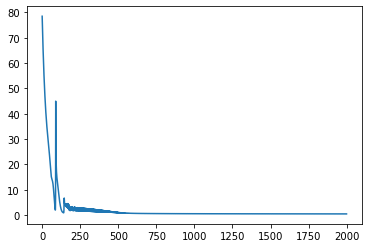

In [127]:
plt.plot(loss_values)

In [128]:
forward_prop_lstm = forward_prop_all(weights, h_init, X)
predicted = np.dot(forward_prop_lstm,weights["W"]) + weights["b"]

Sample output for untrained data

In [136]:
print("Sample input - " + str(X[15]))
print("Actual output - " + str(Y[15]))
print("Predicted output - " + str(predicted[15]))

Sample input - [1 0 1 0]
Actual output - 10
Predicted output - 10.651113597391458


In [138]:
print("Sample input - " + str(X[10]))
print("Actual output - " + str(Y[10]))
print("Predicted output - " + str(predicted[10]))

Sample input - [1 0 0 1]
Actual output - 9
Predicted output - 9.827011885778827


## Question 5

In [1]:
import math
import copy
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             roc_auc_score, accuracy_score, confusion_matrix)
from sklearn.utils import shuffle as skshuffle
from sklearn.model_selection import train_test_split 
from sklearn.datasets import (load_digits, load_breast_cancer)
from keras.utils.np_utils import to_categorical

c:\users\rangr\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\rangr\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\rangr\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

np.random.seed(1000)

In [3]:
breast = load_breast_cancer()
x,y = breast.data , breast.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
x_train = x_train[:,0:25]
x_test = x_test[:,0:25]
x_train.shape

(455, 30) (455,) (114, 30) (114,)


(455, 25)

In [4]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [5]:
x_train[0]

array([1.005e+01, 1.753e+01, 6.441e+01, 3.108e+02, 1.007e-01, 7.326e-02,
       2.511e-02, 1.775e-02, 1.890e-01, 6.331e-02, 2.619e-01, 2.015e+00,
       1.778e+00, 1.685e+01, 7.803e-03, 1.449e-02, 1.690e-02, 8.043e-03,
       2.100e-02, 2.778e-03, 1.116e+01, 2.684e+01, 7.198e+01, 3.840e+02,
       1.402e-01])

In [6]:
x_train = x_train.reshape([455,5,5,1])
x_test = x_test.reshape([114,5,5,1])

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=5, input_shape=(5,5,1), kernel_size=(11,11), strides=(2,2), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 5)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 5)           20        
_________________________________________________________________
activation (Activation)      (None, 3, 3, 5)           0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 5)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 256)         32256     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 256)         0

In [8]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

In [9]:
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(   monitor='val_acc',   factor=.01,   patience=3,  min_lr=1e-5)

In [10]:
#Defining the parameters
batch_size= 100
epochs=100
learn_rate=.001

In [11]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(455, 5, 5, 1) (114, 5, 5, 1) (455, 2) (114, 2)


In [12]:
hist = AlexNet.fit(x=x_train,y=y_train, epochs=200, batch_size=128, verbose=1)

Epoch 1/200
4/4 [==============================] - 9s 1s/step - loss: 0.6174 - accuracy: 0.7062
Epoch 2/200
4/4 [==============================] - 6s 1s/step - loss: 0.2763 - accuracy: 0.9195
Epoch 3/200
4/4 [==============================] - 5s 1s/step - loss: 0.2582 - accuracy: 0.9447
Epoch 4/200
4/4 [==============================] - 6s 1s/step - loss: 0.2389 - accuracy: 0.9382
Epoch 5/200
4/4 [==============================] - 6s 1s/step - loss: 0.2447 - accuracy: 0.9256
Epoch 6/200
4/4 [==============================] - 6s 1s/step - loss: 0.2346 - accuracy: 0.9333
Epoch 7/200
4/4 [==============================] - 6s 1s/step - loss: 0.2253 - accuracy: 0.9438
Epoch 8/200
4/4 [==============================] - 6s 1s/step - loss: 0.2459 - accuracy: 0.9322
Epoch 9/200
4/4 [==============================] - 6s 1s/step - loss: 0.2343 - accuracy: 0.9375
Epoch 10/200
4/4 [==============================] - 6s 1s/step - loss: 0.2500 - accuracy: 0.9372
Epoch 11/200
4/4 [=====================

4/4 [==============================] - 6s 1s/step - loss: 0.0948 - accuracy: 0.9795
Epoch 169/200
4/4 [==============================] - 6s 1s/step - loss: 0.0971 - accuracy: 0.9779
Epoch 170/200
4/4 [==============================] - 6s 1s/step - loss: 0.1078 - accuracy: 0.9719
Epoch 171/200
4/4 [==============================] - 6s 1s/step - loss: 0.0968 - accuracy: 0.9694
Epoch 172/200
4/4 [==============================] - 6s 1s/step - loss: 0.0974 - accuracy: 0.9809
Epoch 173/200
4/4 [==============================] - 6s 1s/step - loss: 0.0906 - accuracy: 0.9808
Epoch 174/200
4/4 [==============================] - 6s 1s/step - loss: 0.0921 - accuracy: 0.9857
Epoch 175/200
4/4 [==============================] - 6s 1s/step - loss: 0.1070 - accuracy: 0.9667
Epoch 176/200
4/4 [==============================] - 6s 1s/step - loss: 0.0846 - accuracy: 0.9802
Epoch 177/200
4/4 [==============================] - 6s 1s/step - loss: 0.0972 - accuracy: 0.9744
Epoch 178/200
4/4 [===============

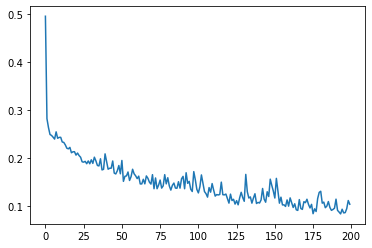

In [13]:
plt.plot(hist.history["loss"])

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

c:\users\rangr\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization


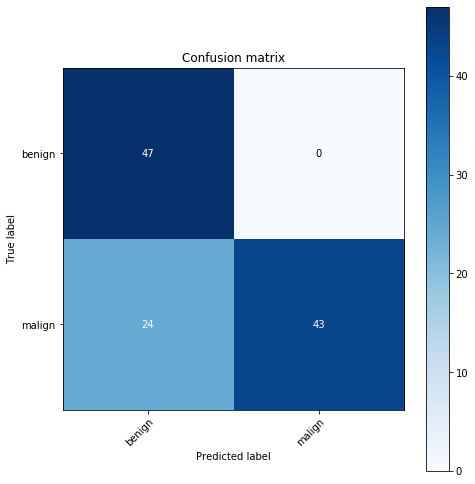

In [15]:
y_pred=AlexNet.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

from sklearn.metrics import confusion_matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names=['benign','malign']

plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix')

In [16]:
confusion_mtx

array([[47,  0],
       [24, 43]], dtype=int64)

In [20]:
from sklearn.metrics import classification_report,confusion_matrix
print("Performance Metrics: ")
metrics=classification_report(y_true,y_pred)
print(metrics)

Performance Metrics: 
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        47
           1       1.00      0.64      0.78        67

    accuracy                           0.79       114
   macro avg       0.83      0.82      0.79       114
weighted avg       0.86      0.79      0.79       114



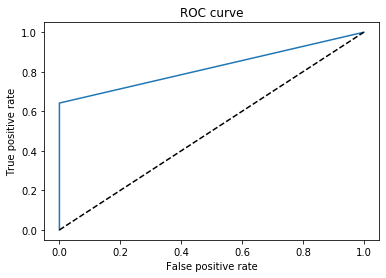

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_true.ravel(), y_pred.ravel())
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()